In [5]:
# Import necessary libraries
import requests
import time
import yaml

# Function to load configuration from a YAML file
def load_config(filepath="config.yaml"):
    """
    Loads API credentials and other settings from a configuration file.
    """
    try:
        with open(filepath, "r") as file:
            return yaml.safe_load(file)
    except Exception as e:
        print(f"Error loading config: {e}")
        raise

# Load the configuration
config = load_config()

# Display a confirmation message
print("Configuration loaded successfully!")

Configuration loaded successfully!


In [6]:
# Function to search for a beer by name
def search_beer(api_config, beer_name):
    """
    Search for beers by name using the Untappd API.
    Returns a list of matching beers.
    """
    url = f"{api_config['base_url']}/search/beer"
    params = {
        "client_id": api_config["client_id"],
        "client_secret": api_config["client_secret"],
        "q": beer_name,
    }

    while True:
        response = requests.get(url, params=params)
        print(f"Searching for beer: {beer_name}... Response: {response.status_code}")
        
        if response.status_code == 429:  # Handle rate limiting
            print("Rate limit reached. Waiting for 60 seconds...")
            time.sleep(60)
            continue

        response.raise_for_status()
        return response.json()["response"]["beers"]["items"]

# Prompt the user to enter a beer name
beer_name = input("Enter the name of the beer you want to search for: ")

# Search for beers
matching_beers = search_beer(config["api"], beer_name)

# Display the results
if matching_beers:
    print("\nMatching Beers:")
    for idx, beer in enumerate(matching_beers, 1):
        print(f"{idx}. {beer['beer']['beer_name']} - {beer['brewery']['brewery_name']}")
else:
    print("No matching beers found.")

Searching for beer: lawdog... Response: 200

Matching Beers:
1. Lawdog Lager - Legal Remedy Brewing
2. Law Dog - Prairie Brothers Brewing Company
3. Law Dog - Nauti Dog Brewing Co.
4. Kansas Law Dog - Huckleberry Brewing Co.
5. Law Dog - The Beer Barn
6. Memphis Law Dog - Hook Point Brewing Company
7. Law Dog - Greenbrier Valley Brewing Company
8. Law Dog - Maple Bacon - Prairie Brothers Brewing Company


In [7]:
# Function to fetch detailed beer information
def fetch_beer_details(api_config, beer_id):
    """
    Fetch detailed information about a beer by its ID.
    """
    url = f"{api_config['base_url']}/beer/info/{beer_id}"
    params = {
        "client_id": api_config["client_id"],
        "client_secret": api_config["client_secret"],
    }

    while True:
        response = requests.get(url, params=params)
        print(f"Fetching details for beer_id {beer_id}... Response: {response.status_code}")
        
        if response.status_code == 429:  # Handle rate limiting
            print("Rate limit reached. Waiting for 60 seconds...")
            time.sleep(60)
            continue

        response.raise_for_status()
        return response.json()["response"]["beer"]

# Allow the user to select a beer
if matching_beers:
    selected_index = int(input("\nEnter the number of the beer to fetch details: ")) - 1
    if 0 <= selected_index < len(matching_beers):
        selected_beer = matching_beers[selected_index]
        beer_id = selected_beer["beer"]["bid"]
        beer_details = fetch_beer_details(config["api"], beer_id)

        # Display beer details
        print("\nBeer Details:")
        print(f"Name: {beer_details['beer_name']}")
        print(f"Style: {beer_details['beer_style']}")
        print(f"ABV: {beer_details['beer_abv']}%")
        print(f"IBU: {beer_details['beer_ibu']}")
        print(f"Description: {beer_details['beer_description']}")
    else:
        print("Invalid selection.")

Fetching details for beer_id 3793475... Response: 200

Beer Details:
Name: Lawdog Lager
Style: Lager - Amber / Red
ABV: 4.3%
IBU: 28
Description: Amber colored lager brewed with Munich and Vienna malts. Malt character is bready, sweet, with a hint of roast. Balanced with a combination of American and German hops.


In [11]:
def fetch_rated_beers_from_db(db_config):
    """
    Connects to the PostgreSQL database and retrieves historical beer ratings and attributes.
    Uses the table name specified in the configuration.
    
    Parameters:
    - db_config: Dictionary containing database connection details, including the table name.

    Returns:
    - A Pandas DataFrame with beer ratings and attributes.
    """
    # Dynamically retrieve the table name from the config
    beer_table = db_config.get("beer_table", "rated_beers")

    # SQL query to fetch beer ratings
    query = f"""
    SELECT 
        beer_id, name AS beer_name, style, abv, ibu, rating_score, user_rating
    FROM 
        {beer_table}
    """

    connection = None
    try:
        # Remove the beer_table key from db_config before connecting
        db_config_copy = db_config.copy()
        db_config_copy.pop("beer_table", None)
        
        # Connect to the database
        connection = psycopg2.connect(**db_config_copy)
        print("Connected to the database successfully.")
        
        # Execute the query and load results into a DataFrame
        df = pd.read_sql_query(query, connection)
        return df

    except Exception as e:
        print(f"Error fetching data from the database: {e}")
        raise

    finally:
        if connection:
            connection.close()

# Fetch beer ratings data using the updated configuration
rated_beers_df = fetch_rated_beers_from_db(config["database"])

# Display the first few rows of the DataFrame
print("Fetched beer ratings data:")
print(rated_beers_df.head())

Connected to the database successfully.
Fetched beer ratings data:
   beer_id          beer_name                           style  abv  ibu  \
0  3095997         Idle Speed          Lager - American Light  4.8    5   
1  4015363  Holiday White Ale  Wheat Beer - Witbier / Blanche  5.8    8   
2  4501493        Juicy Peach                  Sour - Fruited  4.4   10   
3  2493013              Siren     Blonde / Golden Ale - Other  5.2   26   
4   571509          Mango Wit            Wheat Beer - Fruited  5.7    0   

   rating_score  user_rating  
0          3.54          3.0  
1          3.52          2.5  
2          3.65          4.5  
3          3.51          5.0  
4          3.64          0.0  


/var/folders/mg/1tpmkqfs4l11bqqc_hy7_yx40000gn/T/ipykernel_59727/3667943176.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [16]:
# Analyze average ratings by style
import pandas as pd


style_preferences = rated_beers_df.groupby("style")["user_rating"].mean().sort_values(ascending=False)

print("\nYour Average Ratings by Beer Style:")
print(style_preferences)

# Analyze average ratings by ABV
abv_preferences = rated_beers_df.copy()
abv_preferences["abv_range"] = pd.cut(abv_preferences["abv"], bins=[0, 4, 6, 8, 10, 15], 
                                      labels=["0-4%", "4-6%", "6-8%", "8-10%", "10-15%"])
abv_preferences = abv_preferences.groupby("abv_range")["user_rating"].mean()

print("\nYour Average Ratings by ABV Range:")
print(abv_preferences)

# Analyze average ratings by IBU (bitterness)
ibu_preferences = rated_beers_df.copy()
ibu_preferences["ibu_range"] = pd.cut(ibu_preferences["ibu"], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40 ], 
                                      labels=["0-5", "6-10", "11,15", "16-20", "21-25", "26-30", "31-35", "36-40"])
ibu_preferences = ibu_preferences.groupby("ibu_range")["user_rating"].mean()

print("\nYour Average Ratings by IBU Range:")
print(ibu_preferences)


Your Average Ratings by Beer Style:
style
Sour - Fruited                      4.500000
Wheat Beer - American Pale Wheat    4.375000
Blonde / Golden Ale - Other         4.300000
Stout - White / Golden              4.250000
Lager - Mexican                     4.250000
Fruit Beer                          4.125000
Cider - Sweet                       4.000000
Sour - Traditional Gose             4.000000
Sour - Other                        4.000000
Lager - Amber / Red                 4.000000
Sour - Berliner Weisse              4.000000
Shandy / Radler                     3.972222
Sour - Fruited Gose                 3.750000
Blonde / Golden Ale - American      3.625000
Pumpkin / Yam Beer                  3.500000
Altbier - Traditional               3.250000
Porter - Coffee                     3.250000
Wheat Beer - Fruited                3.000000
Lager - American Light              3.000000
IPA - New England / Hazy            3.000000
IPA - American                      3.000000
Cider - Trad

/var/folders/mg/1tpmkqfs4l11bqqc_hy7_yx40000gn/T/ipykernel_59727/2878850356.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  abv_preferences = abv_preferences.groupby("abv_range")["user_rating"].mean()
/var/folders/mg/1tpmkqfs4l11bqqc_hy7_yx40000gn/T/ipykernel_59727/2878850356.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ibu_preferences = ibu_preferences.groupby("ibu_range")["user_rating"].mean()


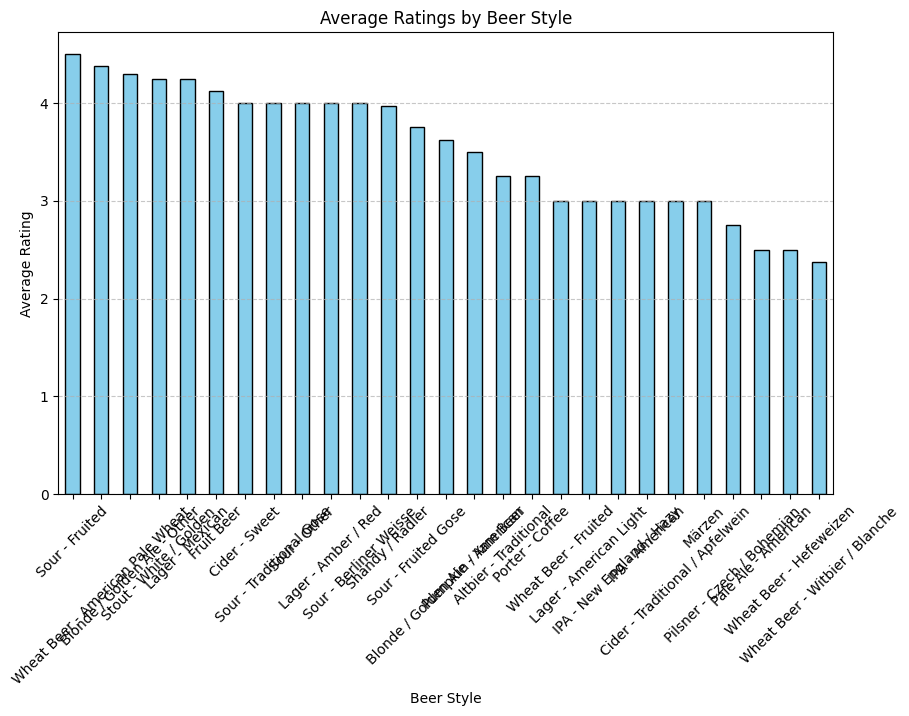

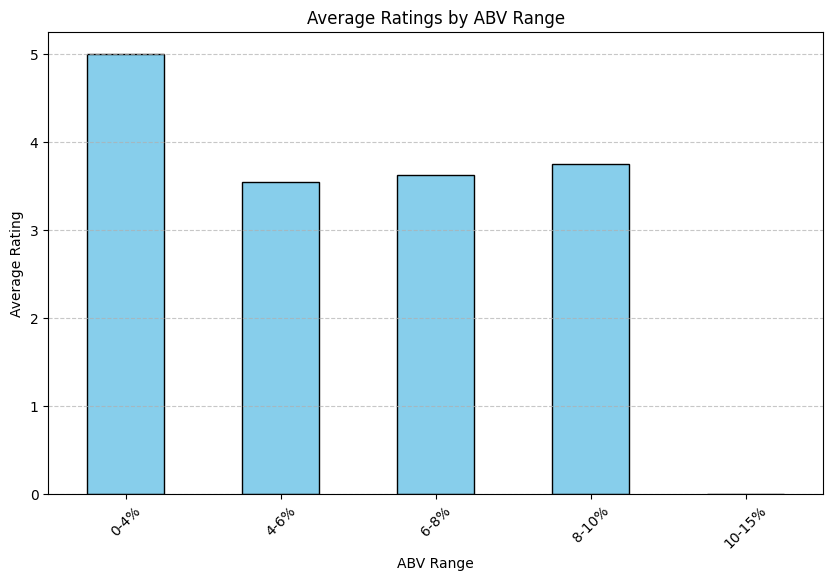

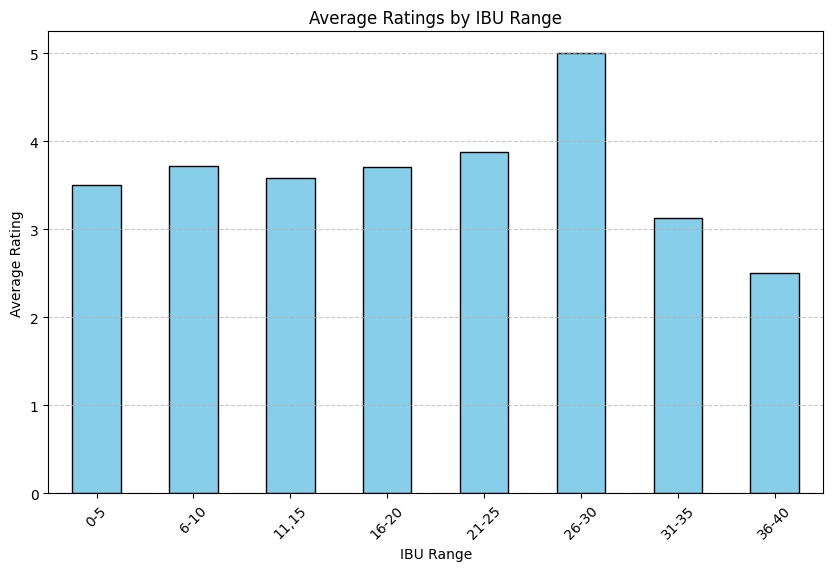

In [17]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt

# Function to create bar charts
def plot_preferences(data, title, xlabel, ylabel):
    """
    Plots a bar chart for the given data.
    """
    plt.figure(figsize=(10, 6))
    data.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Ensure the variables are defined
if 'style_preferences' in globals() and 'abv_preferences' in globals() and 'ibu_preferences' in globals():
    # Plot preferences by style
    plot_preferences(style_preferences, 
                     title="Average Ratings by Beer Style", 
                     xlabel="Beer Style", 
                     ylabel="Average Rating")

    # Plot preferences by ABV range
    plot_preferences(abv_preferences, 
                     title="Average Ratings by ABV Range", 
                     xlabel="ABV Range", 
                     ylabel="Average Rating")

    # Plot preferences by IBU range
    plot_preferences(ibu_preferences, 
                     title="Average Ratings by IBU Range", 
                     xlabel="IBU Range", 
                     ylabel="Average Rating")
else:
    print("Required variables are not defined.")

In [18]:
def calculate_preference_similarity(rated_beers_df, target_beer, preferences):
    """
    Calculate a similarity score that accounts for asymmetric preferences.

    Parameters:
    - rated_beers_df: DataFrame containing your historical beer ratings and attributes.
    - target_beer: Dictionary containing attributes of the beer to compare (style, ABV, IBU).
    - preferences: Dictionary defining preference weights and asymmetric functions for attributes.

    Returns:
    - A DataFrame with similarity scores and ratings for the most similar beers.
    """
    # Extract user-defined preferences
    avg_ibu = preferences["average_ibu"]
    avg_abv = preferences["average_abv"]
    ibu_weight = preferences["ibu_weight"]
    abv_weight = preferences["abv_weight"]
    style_weight = preferences["style_weight"]

    # Prepare numeric similarity scores with asymmetric preferences
    rated_beers_df["ibu_similarity"] = rated_beers_df["ibu"].apply(
        lambda x: max(0, 1 - ibu_weight * abs(x - avg_ibu) / avg_ibu if x < avg_ibu else 1 - 2 * ibu_weight * abs(x - avg_ibu) / avg_ibu)
    )
    rated_beers_df["abv_similarity"] = rated_beers_df["abv"].apply(
        lambda x: max(0, 1 - abv_weight * abs(x - avg_abv) / avg_abv)
    )

    # Style match similarity
    rated_beers_df["style_similarity"] = (rated_beers_df["style"] == target_beer["style"]).astype(int) * style_weight

    # Combine similarities into a total similarity score
    rated_beers_df["similarity"] = (
        rated_beers_df["ibu_similarity"] +
        rated_beers_df["abv_similarity"] +
        rated_beers_df["style_similarity"]
    )

    # Return beers sorted by similarity
    return rated_beers_df.sort_values(by="similarity", ascending=False)

In [19]:
# Ensure the rated_beers_df is defined
if 'rated_beers_df' in globals():
    # Example preference settings
    preferences = {
        "average_ibu": 25,   # Your average IBU
        "average_abv": 5.5,  # Your average ABV
        "ibu_weight": 0.8,   # Weight for IBU (higher = more importance)
        "abv_weight": 0.5,   # Weight for ABV
        "style_weight": 2.0  # Weight for style match
    }

    # Example target beer
    target_beer = {
        "style": "IPA - American",
        "abv": 6.5,
        "ibu": 60
    }

    # Calculate similarity with preferences
    similar_beers_with_preferences = calculate_preference_similarity(rated_beers_df, target_beer, preferences)

    # Display the most similar beers
    print("Most similar beers with preferences considered:")
    print(similar_beers_with_preferences.head())
else:
    print("rated_beers_df is not defined. Please ensure the cell defining rated_beers_df is executed.")

Most similar beers with preferences considered:
    beer_id                       beer_name                        style  abv  \
18  1616467                   Mandarina IPA               IPA - American  5.0   
26  2567548                     Evening Joe  Blonde / Golden Ale - Other  5.7   
25   177436                 Espresso Porter              Porter - Coffee  6.0   
19  1353441  World Court Mocha Blonde Stout       Stout - White / Golden  6.0   
45     4052                    Cherry Wheat         Wheat Beer - Fruited  5.3   

    ibu  rating_score  user_rating  ibu_similarity  abv_similarity  \
18   35          3.62         3.00           0.360        0.954545   
26   25          3.91         4.00           1.000        0.981818   
25   25          3.78         3.25           1.000        0.954545   
19   24          4.03         4.25           0.968        0.954545   
45   23          3.42         4.00           0.936        0.981818   

    style_similarity  similarity  
18       

In [20]:
# Ensure the rated_beers_df is defined
import numpy as np


if 'rated_beers_df' in globals():
    def predict_likelihood_with_preferences(rated_beers_df, target_beer, preferences):
        """
        Predict the likelihood of enjoying the target beer based on preferences.

        Parameters:
        - rated_beers_df: DataFrame containing your historical beer ratings and attributes.
        - target_beer: Dictionary containing attributes of the beer to compare (style, ABV, IBU).
        - preferences: Dictionary defining preference weights and asymmetric functions for attributes.

        Returns:
        - A likelihood score (0 to 1) and a brief explanation.
        """
        # Calculate similarity scores with preferences
        similar_beers = calculate_preference_similarity(rated_beers_df, target_beer, preferences)

        # Use weighted average of ratings for the top similar beers
        top_similar_beers = similar_beers.head(5)  # Take the top 5 similar beers
        if top_similar_beers.empty:
            return 0.0, "No similar beers found in your ratings history."

        # Weighted prediction based on similarity scores
        weights = top_similar_beers["similarity"]
        weighted_rating = np.average(top_similar_beers["user_rating"], weights=weights)

        # Normalize to a likelihood score (0 to 1)
        likelihood_score = min(max(weighted_rating / 5, 0), 1)  # Assuming 5 is the max rating
        explanation = f"The beer is similar to these top styles: {', '.join(top_similar_beers['style'].unique())}."

        return likelihood_score, explanation

    # Predict likelihood for the target beer
    likelihood, explanation = predict_likelihood_with_preferences(rated_beers_df, target_beer, preferences)

    print(f"Likelihood of Enjoyment: {likelihood:.2f}")
    print(f"Explanation: {explanation}")
else:
    print("rated_beers_df is not defined. Please ensure the cell defining rated_beers_df is executed.")

Likelihood of Enjoyment: 0.72
Explanation: The beer is similar to these top styles: IPA - American, Blonde / Golden Ale - Other, Porter - Coffee, Stout - White / Golden, Wheat Beer - Fruited.


In [21]:
import numpy as np


def predict_likelihood_with_average_scores(
    rated_beers_df, target_beer, preferences, target_beer_average_score
):
    """
    Predict the likelihood of enjoying the target beer by incorporating preferences 
    and the beer's average score.

    Parameters:
    - rated_beers_df: DataFrame containing your historical beer ratings and attributes.
    - target_beer: Dictionary containing attributes of the beer to compare (style, ABV, IBU).
    - preferences: Dictionary defining preference weights and asymmetric functions for attributes.
    - target_beer_average_score: The average score of the target beer from Untappd.

    Returns:
    - A likelihood score (0 to 1) and a brief explanation.
    """
    # Calculate similarity scores with preferences
    similar_beers = calculate_preference_similarity(rated_beers_df, target_beer, preferences)

    # Use weighted average of ratings for the top similar beers
    top_similar_beers = similar_beers.head(5)  # Take the top 5 similar beers
    if top_similar_beers.empty:
        return 0.0, "No similar beers found in your ratings history."

    # Weighted prediction based on similarity scores
    weights = top_similar_beers["similarity"]
    weighted_rating = np.average(top_similar_beers["user_rating"], weights=weights)

    # Combine with the target beer's average score
    combined_score = (weighted_rating + target_beer_average_score) / 2

    # Normalize to a likelihood score (0 to 1)
    likelihood_score = min(max(combined_score / 5, 0), 1)  # Assuming 5 is the max rating
    explanation = (
        f"The beer has a high reputation (average score: {target_beer_average_score:.2f}) "
        f"and is similar to your preferences (styles: {', '.join(top_similar_beers['style'].unique())})."
    )

    return likelihood_score, explanation

# Example target beer with average score
target_beer = {
    "style": "IPA - American",
    "abv": 6.5,
    "ibu": 60
}
target_beer_average_score = 4.3  # Example average score from Untappd

# Predict likelihood for the target beer
likelihood, explanation = predict_likelihood_with_average_scores(
    rated_beers_df, target_beer, preferences, target_beer_average_score
)

print(f"Likelihood of Enjoyment: {likelihood:.2f}")
print(f"Explanation: {explanation}")

Likelihood of Enjoyment: 0.79
Explanation: The beer has a high reputation (average score: 4.30) and is similar to your preferences (styles: IPA - American, Blonde / Golden Ale - Other, Porter - Coffee, Stout - White / Golden, Wheat Beer - Fruited).
